In [1]:
# Biblioteker
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [39]:
# Konstanter
g = 9.81
m = 0.0301
c = 2/5
r = 0.020


In [3]:
# Utregning av bane
festepunkter_x = np.arange(0, 1400+200, 200)
festepunkter_y = np.array([300, 247, 159, 159, 195, 190, 131, 152,])

x = np.arange(0, 1400+1, 1)

cs = CubicSpline(festepunkter_x,festepunkter_y,bc_type='natural')
y = cs(x)
dy = cs(x,1)
ddy = cs(x,2)


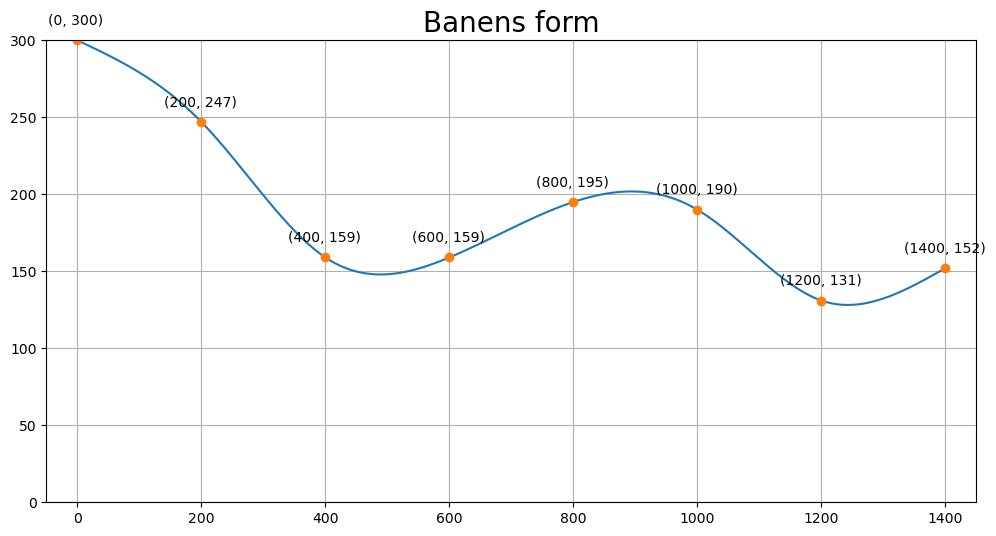

In [4]:
# Plot av banen y(x)
baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Banens form', fontsize=20)
plt.plot(x,y,festepunkter_x,festepunkter_y,'o')
plt.ylim(0,300)
plt.xlim(-50,1450)
plt.grid()

for i, j in zip(festepunkter_x, festepunkter_y):
   strlen = len(f"({str(i)}, {str(j)})")
   plt.text(i-strlen*6, j+10, '({}, {})'.format(i, j))

plt.show()


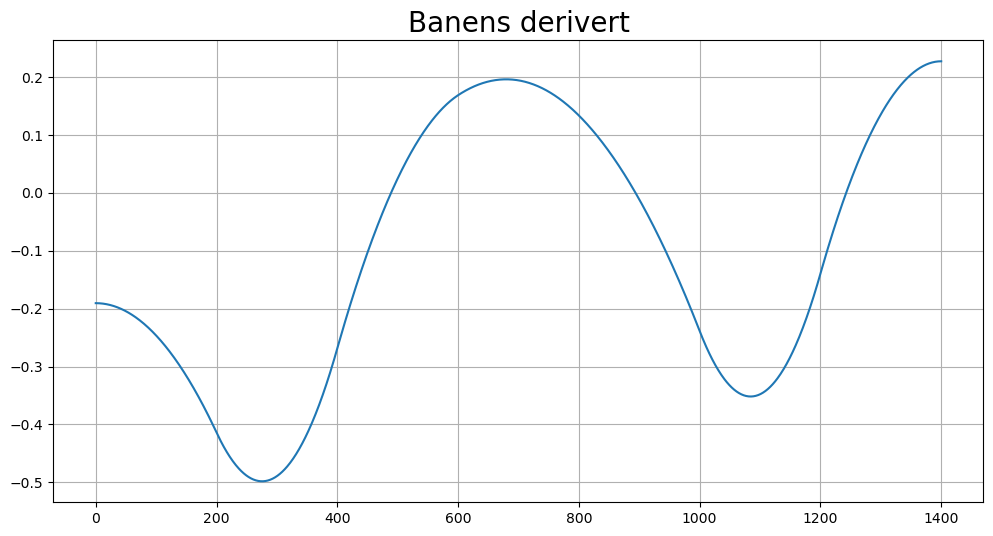

In [5]:
# Plot av derivert av bane
baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Banens derivert', fontsize=20)
plt.plot(x,dy)
plt.grid()
plt.show()


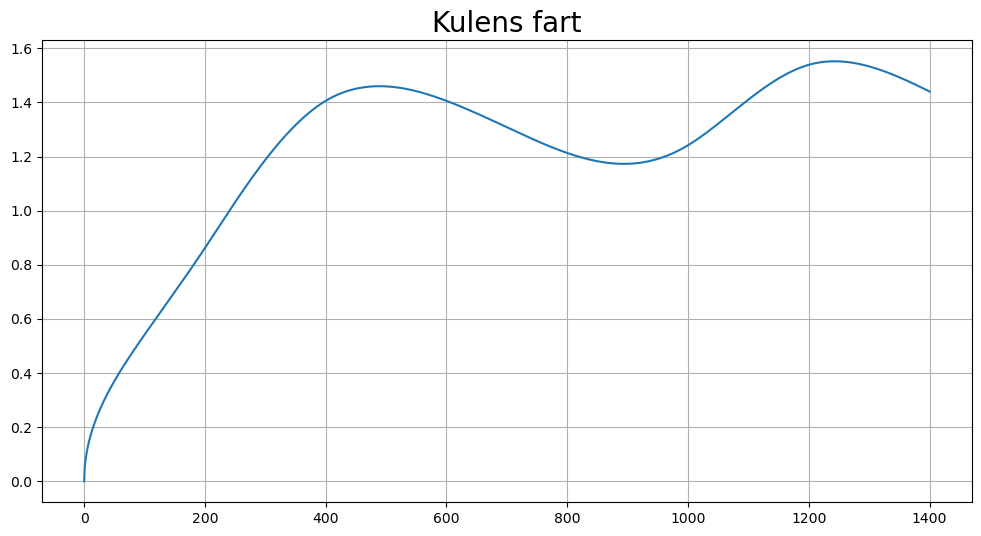

In [6]:
# Plot av kulas fart
def kfart(banehøyde):
    y0 = y[0] / 1000 # m
    return np.sqrt(2*g*(y0-(banehøyde/1000))/(1+c))

baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Kulens fart', fontsize=20)
plt.plot(x, kfart(y))

plt.grid()
plt.show()


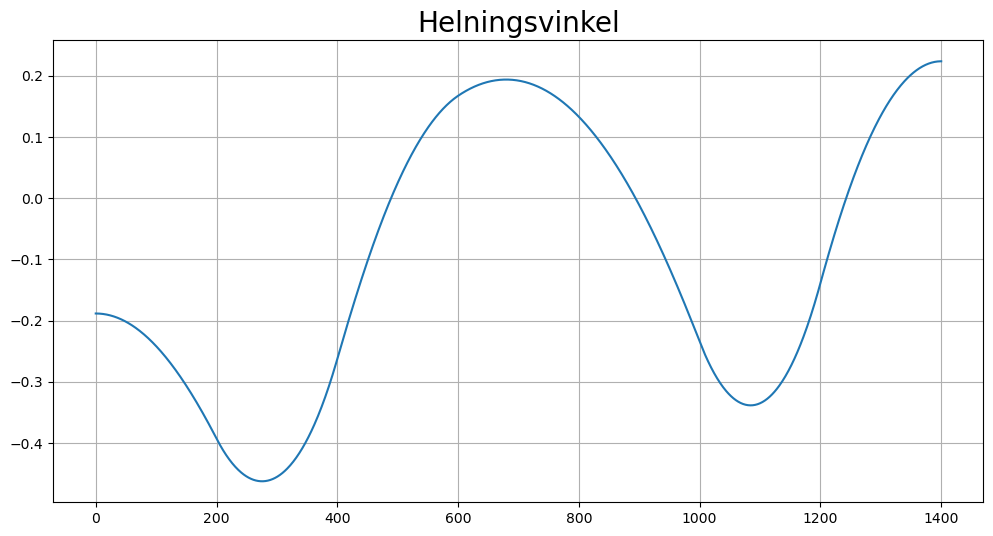

In [7]:
# Plot av helningsvinkel
def helning(dy):
    return np.arctan(dy)

baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Helningsvinkel', fontsize=20)
plt.plot(x, helning(dy))

plt.grid()
plt.show()


In [8]:
# Tidsutvikling
def dt(n):
    dx = 0.001 # m
    fart = kfart(y[n])
    fart_next = kfart(y[n+1])
    return (2 * dx) / ((fart + fart_next) * abs(np.cos(helning(dy[n]))))
dt_arr = [dt(i) for i in range(0, len(x)-1)]


In [9]:
# Total tid
tid = sum(dt_arr)


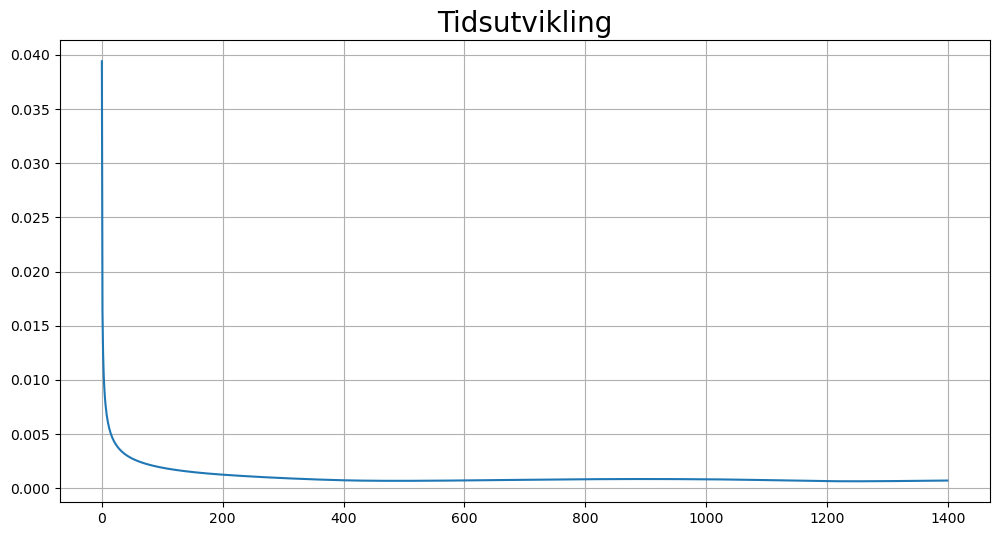

In [10]:
# Plot av tidsutvikling
baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Tidsutvikling', fontsize=20)
plt.plot(x[:-1], dt_arr)
plt.grid()
plt.show()


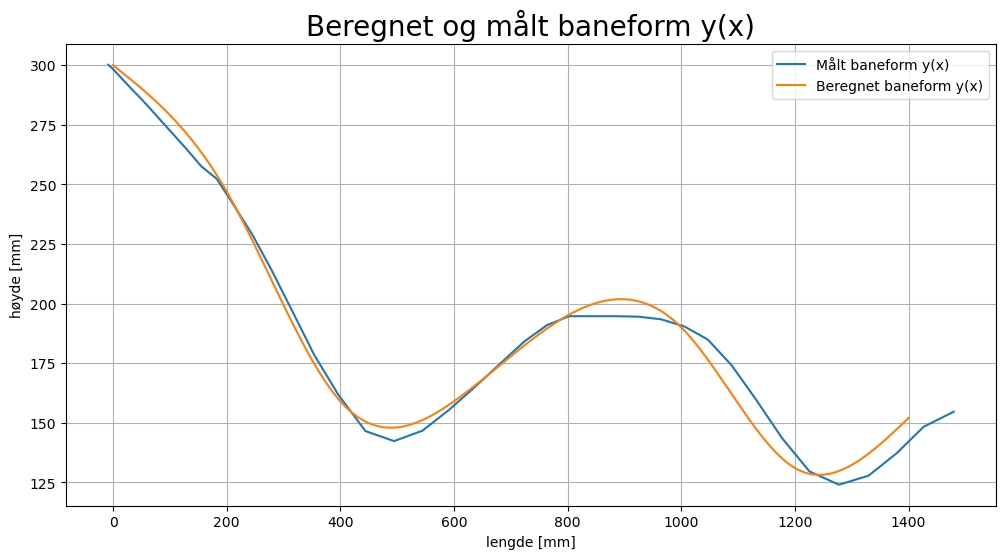

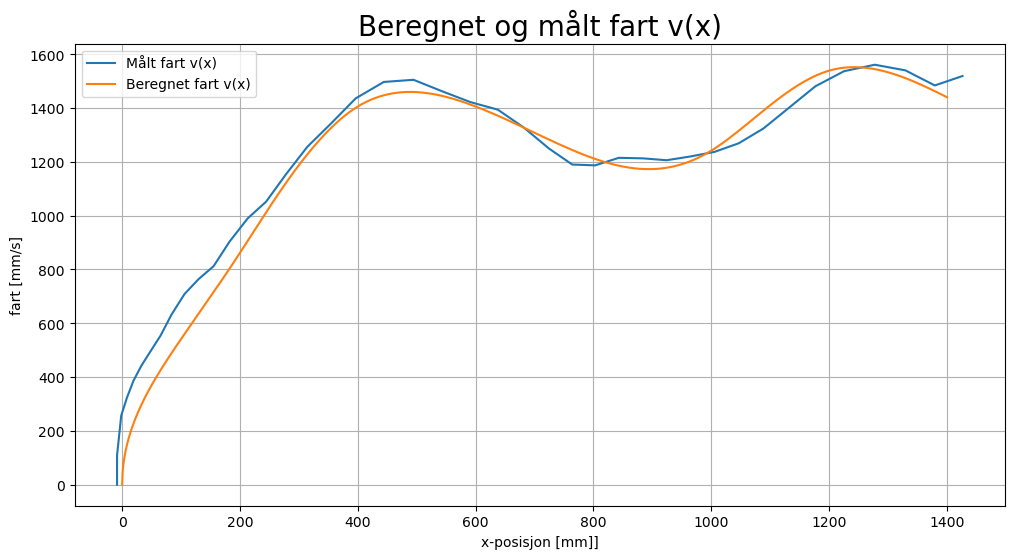

Start mechanical: 0.08864335620000001
End mechanical: 0.07851595535


In [40]:
# Hente ut fra csv
import pandas as pd
data = pd.read_csv('3242.txt', sep=';')
t_exp = data['t'].to_numpy()
x_exp = data['x'].to_numpy()
y_exp = data['y'].to_numpy()
v_exp = data['v'].to_numpy()

speed = np.array([
    np.sqrt((x_exp[i] - x_exp[i-1])**2 + (y_exp[i] - y_exp[i-1])**2) / (t_exp[i] - t_exp[i-1]) for i in range(1, len(x_exp))
])
speed = np.insert(speed, 0, 0)

# Plot av posisjon
baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Beregnet og målt baneform y(x)', fontsize=20)
plt.plot(x_exp*1000, y_exp*1000, label="Målt baneform y(x)")
plt.plot(x, y, label="Beregnet baneform y(x)")
plt.legend()
plt.xlabel("lengde [mm]")
plt.ylabel("høyde [mm]")
plt.grid()
plt.show()

# Plot av fart
baneform = plt.figure('y(x)',figsize=(12,6))
plt.title('Beregnet og målt fart v(x)', fontsize=20)
plt.plot(x_exp*1000, v_exp*1000, label="Målt fart v(x)")
#plt.plot(x_exp, speed, label="Experimental (calculated)")
plt.plot(x, kfart(y)*1000, label="Beregnet fart v(x)")
plt.ylabel("fart [mm/s]")
plt.xlabel("x-posisjon [mm]]")
plt.legend()
plt.grid()
plt.show()

# Calculate energy
def kinetic(v):
    # return (1+c)/2*m*v**2
    return 1/2 * m * v**2
def potential(y):
    return m*g*y
print(f"Start mechanical: {kinetic(v_exp[0]) + potential(y_exp[0])}")
print(f"End mechanical: {kinetic(v_exp[-2]) + potential(y_exp[-2])}")


In [41]:
# Utregning av kinetisk energi i sluttpunktet
E = (1+c)*m*kfart(y[-1]/1000)**2/2
print(E)


0.08853941728800001


In [13]:
def Normalkraft(n):
    y0 = y[0]
    sentrip = (2*g*(y0 - y[n])/(1+c)) * ddy[n]/(1+(dy[n]**2))**(3/2)
    return m*(g*np.cos(helning(dy[n]))+sentrip)


In [14]:
#Friksjonskraft
def F(n): 
    m = 0.031
    g = 9.81
    f = 2*m*g*np.sin(helning(dy[n]))/7
    if abs(f) > 0.4 * Normalkraft(n):
        return 0.4 * Normalkraft(n)
    else:
        return f


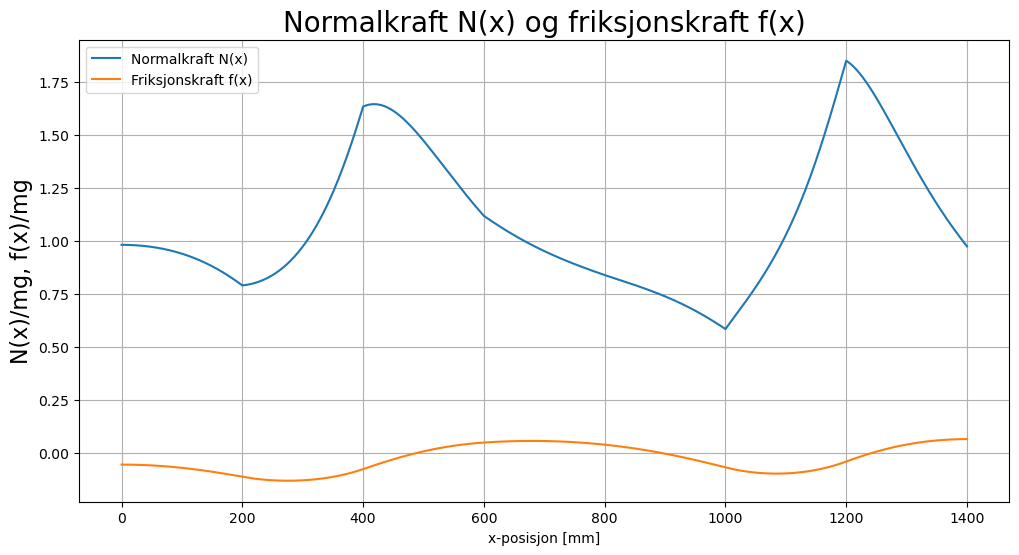

In [22]:
plt.figure('Normalkraft N(x) og friksjonskraft f(x)',figsize=(12,6))
plt.title('Normalkraft N(x) og friksjonskraft f(x)', fontsize=20)
plt.plot(x, Normalkraft(x)/(m*g), label="Normalkraft N(x)")
Friksjonskraft = []
for i in range(len(x)):
    Friksjonskraft.append(F(i))
Friksjonskraft = np.array(Friksjonskraft)
plt.plot(x, Friksjonskraft/(m*g), label="Friksjonskraft f(x)")
plt.legend()
plt.xlabel("x-posisjon [mm]")
plt.ylabel("N(x)/mg, f(x)/mg",fontsize=16)
plt.grid()
plt.show()


In [38]:
#Forholdet mellom friksjonskraften og normalkraften
def aFrictionousRelationship(n):
    return F(n)/Normalkraft(n)

152.0


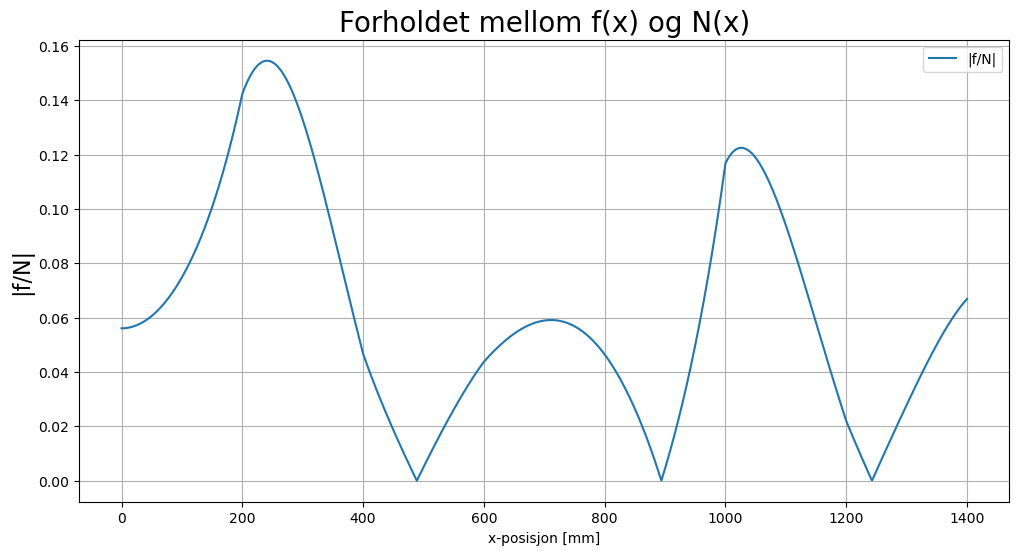

In [21]:
plt.figure('Forholdet mellom f(x) og N(x)',figsize=(12,6))
plt.title('Forholdet mellom f(x) og N(x)', fontsize=20)
plt.plot(x, abs(Friksjonskraft/Normalkraft(x)), label="|f/N|")
plt.legend()
plt.xlabel("x-posisjon [mm]")
plt.ylabel("|f/N|",fontsize=16)
plt.grid()
plt.show()

In [29]:
import numpy as np

# Eksperimentelle data og middelverdier
Videos       = [3241,   3242,   3243,   3244,   3245,   3248,   3250,   3251,   3252,   3253]
total_time   = [1.4014, 1.4014, 1.3680, 1.4014, 1.4014, 1.4014, 1.4000, 1.4348, 1.4014, 1.4014]
end_velocity = [1.367,  1.519,  1.461,  1.499,  1.313,  1.448,  1.463,  1.4489, 1.4472, 1.449]

y_start = [0.3002, 0.3002, 0.2995, 0.2996, 0.3005, 0.3000, 0.2999, 0.3015, 0.3001, 0.3003]
y_end   = [0.1498, 0.1483, 0.1395, 0.1407, 0.1495, 0.1421, 0.1432, 0.1455, 0.1495, 0.1448]

def kinetic(v_list):
    end_kinetic = []
    for v in v_list:
        end_kinetic.append((1+c)/2 * m * v**2)
    return end_kinetic
end_kinetic = kinetic(end_velocity)

def potential(y):
    return m*g*y

def mechanical(end_kinetic, y_end):
    energies = []
    for idx in range (len(end_kinetic)):
        energies.append(potential(y_end[idx]) + end_kinetic[idx])
    return energies
print("Start and end mechanical energy:")
print([round(n, 3) for n in mechanical([0]*10, y_start)])
print([round(n, 3) for n in mechanical(end_kinetic, y_end)])

def delta_mechanical(end_kinetic,y_start,y_end):
    delta_mech_energy = []
    for idx in range (len(end_kinetic)):
        start_mech_energy = potential(y_start[idx])
        end_mech_energy = potential(y_end[idx]) + end_kinetic[idx]
        delta_mech_energy.append(end_mech_energy-start_mech_energy)
    return delta_mech_energy


start_mech_energy = [potential(element) for element in y_start] 
delta_mech_energy = delta_mechanical(end_kinetic,y_start,y_end)

def mean_value(liste):
    mean = 0
    for element in liste:
        mean += element
    return mean/len(liste)

def standard_deviation(liste):
    stand_dev = 0
    mean = mean_value(liste)
    for element in liste:
        stand_dev += (element - mean)**2
    stand_dev /= (len(liste)-1)
    return np.sqrt(stand_dev)

def standard_error(liste):
    stand_err = 0
    stand_dev = standard_deviation(liste)
    stand_err = stand_dev/(np.sqrt(len(liste)))
    return stand_err
    
def print_values(liste, name, unit):
    print(f"The mean value of {name} is {round(mean_value(liste),4)} {unit}.")
    print(f"The standard deviation of {name} is {round(standard_deviation(liste),4)} {unit}.")
    print(f"The standard error of {name} is {round(standard_error(liste),4)} {unit}. \n")

print(end_velocity)
print(end_kinetic)
print(delta_mech_energy)    
print_values(total_time,"total time", "s")
print_values(end_velocity,"end velocity", "m/s")
print_values(end_kinetic,"end kinetic energy", "J")
print_values(delta_mech_energy,"change in mechanical energi", "J")

print_values(list((np.array(delta_mech_energy)/np.array(start_mech_energy))*100), "change in mechanical energi", "%")


Start and end mechanical energy:
[0.089, 0.089, 0.088, 0.088, 0.089, 0.089, 0.089, 0.089, 0.089, 0.089]
[0.084, 0.092, 0.086, 0.089, 0.08, 0.086, 0.087, 0.087, 0.088, 0.087]
[1.367, 1.519, 1.461, 1.499, 1.313, 1.448, 1.463, 1.4489, 1.4472, 1.449]
[0.039373277229999996, 0.04861609626999999, 0.044974357470000004, 0.047344311070000006, 0.036324026829999995, 0.04417755328, 0.04509757483, 0.0442324871947, 0.0441287517888, 0.044238593070000005]
[-0.005036985170000022, 0.0037629123699999822, -0.002270602529999985, 0.00042416017000000694, -0.008263404170000002, -0.0024473166200000007, -0.0011729578700000048, -0.0018313488053000038, -0.00034056681119999654, -0.0016776024299999942]
The mean value of total time is 1.4013 s.
The standard deviation of total time is 0.0158 s.
The standard error of total time is 0.005 s. 

The mean value of end velocity is 1.4415 m/s.
The standard deviation of end velocity is 0.06 m/s.
The standard error of end velocity is 0.019 m/s. 

The mean value of end kinetic e

| Forsøk | Rulletid | Sluttfart | Mekanisk energi (start) | Mekanisk energi (slutt) |
| -: | -: | -: | -: | -: |
| 1  | 1.4014 | 1.367  | 0.089 | 0.084 |
| 2  | 1.4014 | 1.519  | 0.089 | 0.092 |
| 3  | 1.3680 | 1.461  | 0.088 | 0.086 |
| 4  | 1.4014 | 1.499  | 0.088 | 0.089 |
| 5  | 1.4014 | 1.313  | 0.089 | 0.08  |
| 6  | 1.4014 | 1.448  | 0.089 | 0.086 |
| 7  | 1.4000 | 1.463  | 0.089 | 0.087 |
| 8  | 1.4348 | 1.4489 | 0.089 | 0.087 |
| 9  | 1.4014 | 1.4472 | 0.089 | 0.088 |
| 10 | 1.4014 | 1.449  | 0.089 | 0.087 |